# What Is Optimization in Plain English?

This notebook demonstrates what optimization actually does: it **systematically searches** for the best solution from many possible options.

Understanding this is critical because:
- Optimization does **not** create solutions; it finds the best from what is possible
- Optimization is **systematic search**, not magic
- If all possible solutions are poor, optimization finds the best poor solution
- Understanding what optimization does helps you set realistic expectations


## Key Concepts

**Optimization** is the process of finding the best solution from many possible options:
- It systematically explores options and evaluates them against your objectives
- It finds the solution that best achieves your goals while respecting constraints
- It is like having a smart assistant that considers thousands of possibilities you could never evaluate manually

**What optimization does NOT do**:
- It does not create perfect solutions out of thin air
- It does not guarantee success
- It does not work with bad data or bad framing

**Critical insight**: Optimization finds the best solution from what is possible. If the possible solutions are all poor, optimization will find the best poor solution.


## Scenario: Production Planning

You manage a factory that produces two products: Product A and Product B. You need to decide how many units of each to produce.

**Decision variables**: How many units of Product A and Product B to produce

**Objective**: Maximize total profit

**Constraints**:
- Production capacity: 2,000 total units
- Labor hours: 1,500 hours available
- Demand limits: Cannot exceed forecasted demand

There are **many possible solutions** (different combinations of A and B). Optimization systematically searches through them to find the best one.


## Step 1: Install Required Packages (Colab)

If you're running this notebook in Google Colab, you need to install the `pulp` package first. This cell can be skipped if running locally and the package is already installed.


In [1]:
# Install pulp package (required for optimization)
# This is needed in Google Colab; can be skipped if already installed locally
%pip install pulp -q



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


## Step 2: Import Libraries


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pulp import LpMaximize, LpProblem, LpVariable, lpSum, value


## Step 3: Define the Problem

Let's set up a simple production planning problem:


In [3]:
# Problem inputs (what we know)
profit_A = 50  # Profit per unit of Product A ($)
profit_B = 40  # Profit per unit of Product B ($)

capacity = 2000  # Total production capacity (units)
labor_hours = 1500  # Available labor hours
labor_per_A = 0.5  # Labor hours per unit of A
labor_per_B = 0.8  # Labor hours per unit of B

demand_A = 1200  # Maximum demand for Product A
demand_B = 1000  # Maximum demand for Product B

print("PROBLEM SETUP:")
print(f"  Profit per A: ${profit_A}")
print(f"  Profit per B: ${profit_B}")
print(f"  Capacity: {capacity} units")
print(f"  Labor hours: {labor_hours} hours")
print(f"  Demand A: {demand_A} units")
print(f"  Demand B: {demand_B} units")


PROBLEM SETUP:
  Profit per A: $50
  Profit per B: $40
  Capacity: 2000 units
  Labor hours: 1500 hours
  Demand A: 1200 units
  Demand B: 1000 units


## Step 4: Visualize the Space of Possible Solutions

Let's visualize all the possible solutions (combinations of A and B that satisfy constraints):


In [4]:
# Create a grid of possible solutions
A_values = np.arange(0, demand_A + 100, 50)
B_values = np.arange(0, demand_B + 100, 50)

# Calculate which solutions are feasible
feasible_solutions = []
infeasible_solutions = []

for a in A_values:
    for b in B_values:
        # Check constraints
        capacity_ok = (a + b <= capacity)
        labor_ok = (labor_per_A * a + labor_per_B * b <= labor_hours)
        demand_ok = (a <= demand_A) and (b <= demand_B)
        
        if capacity_ok and labor_ok and demand_ok:
            profit = profit_A * a + profit_B * b
            feasible_solutions.append({'A': a, 'B': b, 'Profit': profit})
        else:
            infeasible_solutions.append({'A': a, 'B': b})

# Convert to DataFrame for easier handling
feasible_df = pd.DataFrame(feasible_solutions)
infeasible_df = pd.DataFrame(infeasible_solutions)

print(f"Number of feasible solutions in our sample: {len(feasible_solutions)}")
print(f"Number of infeasible solutions in our sample: {len(infeasible_solutions)}")
print(f"\nNote: In reality, there are many more possible solutions (continuous values).")


Number of feasible solutions in our sample: 515
Number of infeasible solutions in our sample: 57

Note: In reality, there are many more possible solutions (continuous values).


## Step 5: Visualize All Possible Solutions

This visualization shows the "space" of all possible solutions:


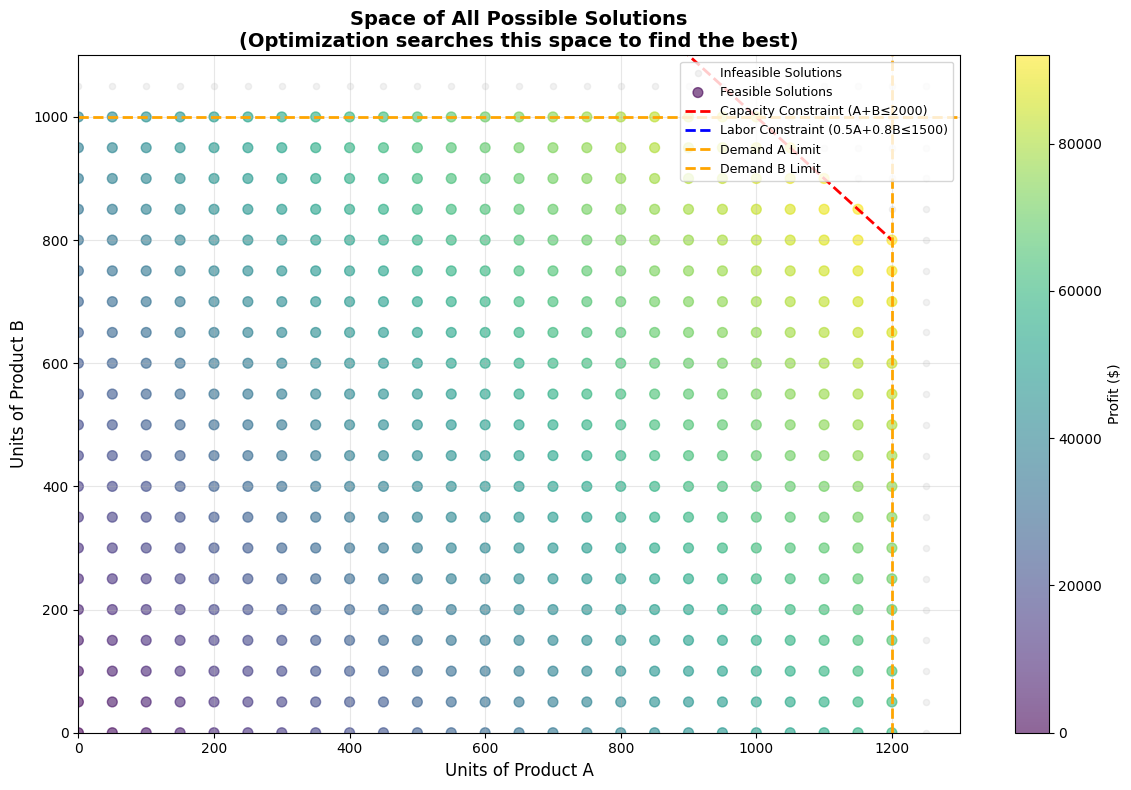


Key Insight:
  - The gray area shows infeasible solutions (violate constraints)
  - The colored area shows feasible solutions
  - Color intensity shows profit (darker = higher profit)
  - Optimization searches through feasible solutions to find the best one


In [5]:
fig, ax = plt.subplots(figsize=(12, 8))

# Plot infeasible solutions (gray)
if len(infeasible_df) > 0:
    ax.scatter(infeasible_df['A'], infeasible_df['B'], 
               c='lightgray', s=20, alpha=0.3, label='Infeasible Solutions')

# Plot feasible solutions (colored by profit)
if len(feasible_df) > 0:
    scatter = ax.scatter(feasible_df['A'], feasible_df['B'], 
                         c=feasible_df['Profit'], s=50, alpha=0.6, 
                         cmap='viridis', label='Feasible Solutions')
    plt.colorbar(scatter, ax=ax, label='Profit ($)')

# Draw constraint lines
A_line = np.linspace(0, demand_A, 100)

# Capacity constraint: A + B <= 2000
B_capacity = capacity - A_line
ax.plot(A_line, B_capacity, 'r--', linewidth=2, label='Capacity Constraint (A+B≤2000)')

# Labor constraint: 0.5A + 0.8B <= 1500
B_labor = (labor_hours - labor_per_A * A_line) / labor_per_B
B_labor = np.maximum(0, B_labor)  # Only positive values
ax.plot(A_line, B_labor, 'b--', linewidth=2, label='Labor Constraint (0.5A+0.8B≤1500)')

# Demand constraints
ax.axvline(x=demand_A, color='orange', linestyle='--', linewidth=2, label='Demand A Limit')
ax.axhline(y=demand_B, color='orange', linestyle='--', linewidth=2, label='Demand B Limit')

ax.set_xlabel('Units of Product A', fontsize=12)
ax.set_ylabel('Units of Product B', fontsize=12)
ax.set_title('Space of All Possible Solutions\n(Optimization searches this space to find the best)', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, demand_A + 100)
ax.set_ylim(0, demand_B + 100)

plt.tight_layout()
plt.show()

print("\nKey Insight:")
print("  - The gray area shows infeasible solutions (violate constraints)")
print("  - The colored area shows feasible solutions")
print("  - Color intensity shows profit (darker = higher profit)")
print("  - Optimization searches through feasible solutions to find the best one")


In [6]:
# Try some manual solutions
manual_solutions = [
    {'A': 500, 'B': 500, 'Name': 'Equal Split'},
    {'A': 1000, 'B': 500, 'Name': 'More A'},
    {'A': 500, 'B': 1000, 'Name': 'More B'},
    {'A': 800, 'B': 800, 'Name': 'Balanced'},
    {'A': 1200, 'B': 300, 'Name': 'Max A'}
]

manual_results = []
for sol in manual_solutions:
    a, b = sol['A'], sol['B']
    
    # Check feasibility
    capacity_ok = (a + b <= capacity)
    labor_ok = (labor_per_A * a + labor_per_B * b <= labor_hours)
    demand_ok = (a <= demand_A) and (b <= demand_B)
    
    feasible = capacity_ok and labor_ok and demand_ok
    profit = profit_A * a + profit_B * b if feasible else 0
    
    manual_results.append({
        'Name': sol['Name'],
        'A': a,
        'B': b,
        'Feasible': 'Yes' if feasible else 'No',
        'Profit': profit if feasible else 'N/A'
    })

manual_df = pd.DataFrame(manual_results)
print("MANUAL EVALUATION (Trying a few solutions):")
print("=" * 60)
display(manual_df)

best_manual = manual_df[manual_df['Feasible'] == 'Yes']['Profit'].max()
print(f"\nBest profit from manual evaluation: ${best_manual:,.0f}")
print("\nProblem: There are thousands of possible solutions!")
print("You cannot manually evaluate all of them.")


MANUAL EVALUATION (Trying a few solutions):


,Name,A,B,Feasible,Profit
0,Equal Split,500,500,Yes,45000
1,More A,1000,500,Yes,70000
2,More B,500,1000,Yes,65000
3,Balanced,800,800,Yes,72000
4,Max A,1200,300,Yes,72000



Best profit from manual evaluation: $72,000

Problem: There are thousands of possible solutions!
You cannot manually evaluate all of them.


## Step 7: Optimization (Systematic Search)

Now let's use optimization to systematically search for the best solution:


In [7]:
# Create optimization model
model = LpProblem("Production_Optimization", LpMaximize)

# Decision variables
produce_A = LpVariable("produce_A", lowBound=0, cat='Continuous')
produce_B = LpVariable("produce_B", lowBound=0, cat='Continuous')

# Objective: Maximize profit
model += profit_A * produce_A + profit_B * produce_B, "Total_Profit"

# Constraints
model += produce_A + produce_B <= capacity, "Capacity_Limit"
model += labor_per_A * produce_A + labor_per_B * produce_B <= labor_hours, "Labor_Limit"
model += produce_A <= demand_A, "Demand_A_Limit"
model += produce_B <= demand_B, "Demand_B_Limit"

# Solve
model.solve()

# Get solution
optimal_A = value(produce_A)
optimal_B = value(produce_B)
optimal_profit = value(model.objective)

print("OPTIMIZATION RESULT (Systematic Search):")
print("=" * 60)
print(f"  Produce {optimal_A:.1f} units of Product A")
print(f"  Produce {optimal_B:.1f} units of Product B")
print(f"  Total Profit: ${optimal_profit:,.2f}")
print(f"\nOptimization systematically searched through all possible solutions")
print(f"and found the one that maximizes profit while satisfying all constraints.")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sturner/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/4e70830c870b4ba2a9f1dac4a93066d3-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/4e70830c870b4ba2a9f1dac4a93066d3-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 9 COLUMNS
At line 18 RHS
At line 23 BOUNDS
At line 24 ENDATA
Problem MODEL has 4 rows, 2 columns and 6 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 1 (-3) rows, 2 (0) columns and 2 (-4) elements
0  Obj -0 Dual inf 89.999998 (2)
1  Obj 92000
Optimal - objective value 92000
After Postsolve, objective 92000, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 92000 - 1 iterations time 0.002, Presolve 0.00
Option for prin

## Step 8: Compare Manual vs Optimization

Let's compare what we found manually vs what optimization found:


In [8]:
# Add optimal solution to comparison
best_manual_idx = manual_df[manual_df['Feasible'] == 'Yes']['Profit'].idxmax()
best_manual_row = manual_df.loc[best_manual_idx]

comparison = pd.DataFrame({
    'Method': ['Manual (Best)', 'Optimization'],
    'A': [best_manual_row['A'], optimal_A],
    'B': [best_manual_row['B'], optimal_B],
    'Profit': [best_manual, optimal_profit],
    'Difference': [0, optimal_profit - best_manual]
})

print("COMPARISON: Manual Evaluation vs Optimization")
print("=" * 60)
display(comparison.round(2))

improvement = ((optimal_profit - best_manual) / best_manual) * 100
print(f"\nOptimization found a solution that is {improvement:.1f}% better!")
print("\nKey Insight:")
print("  - Manual evaluation: Try a few solutions, pick the best")
print("  - Optimization: Systematically search ALL possible solutions")
print("  - Optimization finds the best solution from what is possible")


COMPARISON: Manual Evaluation vs Optimization


,Method,A,B,Profit,Difference
0,Manual (Best),800.0,800.0,72000.0,0.0
1,Optimization,1200.0,800.0,92000.0,20000.0



Optimization found a solution that is 27.8% better!

Key Insight:
  - Manual evaluation: Try a few solutions, pick the best
  - Optimization: Systematically search ALL possible solutions
  - Optimization finds the best solution from what is possible


## Step 9: Visualize the Optimal Solution

Let's see where the optimal solution is in the space of all possible solutions:


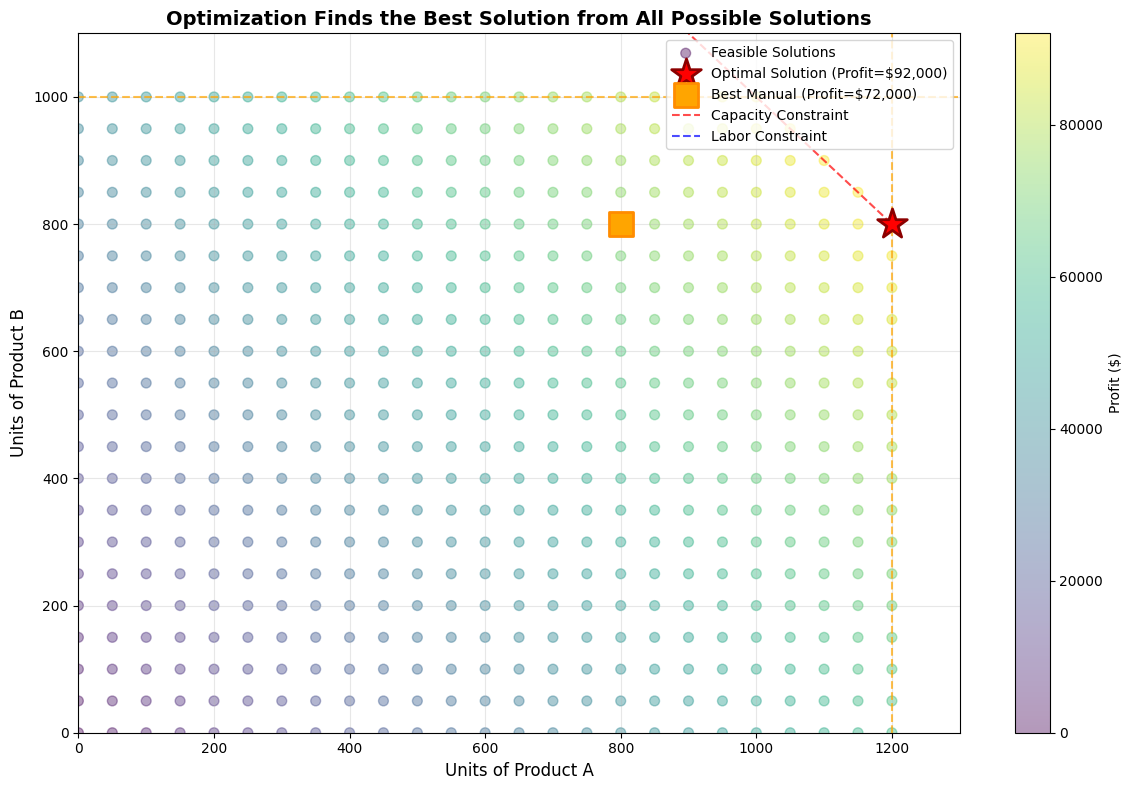


Key Insight:
  - The red star shows the optimal solution (best profit)
  - Optimization systematically searched through all feasible solutions
  - It found the best one from what is possible


In [9]:
fig, ax = plt.subplots(figsize=(12, 8))

# Plot feasible solutions (colored by profit)
if len(feasible_df) > 0:
    scatter = ax.scatter(feasible_df['A'], feasible_df['B'], 
                         c=feasible_df['Profit'], s=50, alpha=0.4, 
                         cmap='viridis', label='Feasible Solutions')
    plt.colorbar(scatter, ax=ax, label='Profit ($)')

# Plot optimal solution (large red star)
ax.scatter(optimal_A, optimal_B, s=500, marker='*', 
           color='red', edgecolor='darkred', linewidth=2, 
           label=f'Optimal Solution (Profit=${optimal_profit:,.0f})', zorder=10)

# Plot best manual solution
ax.scatter(best_manual_row['A'], best_manual_row['B'], s=300, marker='s', 
           color='orange', edgecolor='darkorange', linewidth=2, 
           label=f"Best Manual (Profit=${best_manual:,.0f})", zorder=9)

# Draw constraint lines
A_line = np.linspace(0, demand_A, 100)
B_capacity = capacity - A_line
ax.plot(A_line, B_capacity, 'r--', linewidth=1.5, alpha=0.7, label='Capacity Constraint')

B_labor = (labor_hours - labor_per_A * A_line) / labor_per_B
B_labor = np.maximum(0, B_labor)
ax.plot(A_line, B_labor, 'b--', linewidth=1.5, alpha=0.7, label='Labor Constraint')

ax.axvline(x=demand_A, color='orange', linestyle='--', linewidth=1.5, alpha=0.7)
ax.axhline(y=demand_B, color='orange', linestyle='--', linewidth=1.5, alpha=0.7)

ax.set_xlabel('Units of Product A', fontsize=12)
ax.set_ylabel('Units of Product B', fontsize=12)
ax.set_title('Optimization Finds the Best Solution from All Possible Solutions', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, demand_A + 100)
ax.set_ylim(0, demand_B + 100)

plt.tight_layout()
plt.show()

print("\nKey Insight:")
print("  - The red star shows the optimal solution (best profit)")
print("  - Optimization systematically searched through all feasible solutions")
print("  - It found the best one from what is possible")


## Step 10: What If All Solutions Are Poor?

An important insight: if all possible solutions are poor, optimization finds the best poor solution. Let's demonstrate:


In [10]:
# Scenario: Poor profit margins (all solutions are poor)
poor_profit_A = 5  # Very low profit per unit
poor_profit_B = 4  # Very low profit per unit

# Create model with poor profits
model_poor = LpProblem("Production_Poor_Profits", LpMaximize)

produce_A_poor = LpVariable("produce_A_poor", lowBound=0, cat='Continuous')
produce_B_poor = LpVariable("produce_B_poor", lowBound=0, cat='Continuous')

model_poor += poor_profit_A * produce_A_poor + poor_profit_B * produce_B_poor, "Total_Profit"

# Same constraints
model_poor += produce_A_poor + produce_B_poor <= capacity, "Capacity_Limit"
model_poor += labor_per_A * produce_A_poor + labor_per_B * produce_B_poor <= labor_hours, "Labor_Limit"
model_poor += produce_A_poor <= demand_A, "Demand_A_Limit"
model_poor += produce_B_poor <= demand_B, "Demand_B_Limit"

model_poor.solve()

optimal_A_poor = value(produce_A_poor)
optimal_B_poor = value(produce_B_poor)
optimal_profit_poor = value(model_poor.objective)

print("SCENARIO: Poor Profit Margins")
print("=" * 60)
print(f"  Profit per A: ${poor_profit_A} (was ${profit_A})")
print(f"  Profit per B: ${poor_profit_B} (was ${profit_B})")
print(f"\n  Optimal Solution:")
print(f"    Produce {optimal_A_poor:.1f} units of A")
print(f"    Produce {optimal_B_poor:.1f} units of B")
print(f"    Total Profit: ${optimal_profit_poor:,.2f}")
print(f"\n  Original Optimal Profit: ${optimal_profit:,.2f}")
print(f"  New Optimal Profit: ${optimal_profit_poor:,.2f}")
print(f"\nKey Insight:")
print(f"  - Optimization found the BEST solution from what is possible")
print(f"  - But if all solutions are poor, the best is still poor")
print(f"  - Optimization does not create good solutions; it finds the best from what exists")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sturner/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/eec9c761244947db8c392d940cb952ed-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/eec9c761244947db8c392d940cb952ed-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 9 COLUMNS
At line 18 RHS
At line 23 BOUNDS
At line 24 ENDATA
Problem MODEL has 4 rows, 2 columns and 6 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 1 (-3) rows, 2 (0) columns and 2 (-4) elements
0  Obj -0 Dual inf 8.999998 (2)
1  Obj 9200
Optimal - objective value 9200
After Postsolve, objective 9200, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 9200 - 1 iterations time 0.002, Presolve 0.00
Option for printingO

## Summary: What Is Optimization?

**Optimization** is systematic search for the best solution:
- It explores many possible solutions
- It evaluates them against your objectives
- It finds the one that best achieves your goals while respecting constraints

**What optimization does NOT do**:
- It does not create solutions out of thin air
- It does not guarantee perfect outcomes
- It does not work miracles

**Critical insight**: 
- Optimization finds the **best solution from what is possible**
- If all possible solutions are poor, optimization finds the best poor solution
- Understanding this helps you set realistic expectations

**Practical implication**:
- Good framing and good inputs lead to good optimization results
- Poor framing or poor inputs lead to poor results, even with perfect optimization
- Optimization is a tool that finds the best from what you give it
